# Recruitment Across Datasets

In this notebook, we further examine the capability of ODIF to transfer across datasets, building upon the prior FTE/BTE experiments on MNIST and Fashion-MNIST. Using the datasets found in [this repo](https://github.com/neurodata/LLF_tidy_images), we perform a series of experiments to evaluate the transfer efficiency and recruitment capabilities of ODIF across five different datasets. The datasets and their content are as follows:
- Caltech-101: contains images of objects in 101 categories
- CIFAR-10: contains 32x32 color images of objects in 10 classes
- CIFAR-100: contains 32x32 color images of objects in 100 classes
- Food-101: contains images of dishes in 101 categories
- DTD: contains images of describable textures

In [1]:
import functions.recruitacrossdatasets_functions as fn

**Note:** This notebook tutorial uses functions stored externally within `functions/recruitacrossdatasets_functions.py` to simplify presentation of code. These functions are imported above, along with other libraries.

## FTE/BTE Experiment

We begin our examination of ODIF's transfer capabilities across datasets with the FTE/BTE experiment, which provides background metrics for what the expected performance should be. This helps inform the later recruitment experiment.

### Base Experiment
#### Import and Process Data

Let's first import the data and perform some preprocessing so that it is in the correct format for feeding to ODIF. The following function does so for us:

In [2]:
data, classes = fn.import_data(normalize=False)

#### Define Hyperparameters

We then define the hyperparameters to be used for the experiment:
- `model`: model to be used for FTE/BTE experiment
- `num_tasks`: number of tasks
- `num_trees`: nuber of trees
- `reps`: number of repetitions, fewer than actual figures to reduce running time

In [3]:
##### MAIN HYPERPARAMS ##################
model = "odif"
num_tasks = 5
num_trees = 10
reps = 4
#########################################

Taking each dataset as a separate task, we have `5` tasks, and we also set a default of `10` trees, with the experiment being run for `30` reps.

Note, in comparison to previous FTE/BTE experiments, the lack of the `num_points_per_task` parameter. Here, we sample based on the label with the least number of samples and take 31 samples from each label.

#### Run Experiment and Plot Results

First, we call the function to run the experiment:

In [4]:
accuracy_all_task = fn.ftebte_exp(
    data, classes, model, num_tasks, num_trees, reps, shift=0
)

Using the accuracies over all tasks, we can calculate the error, the forwards transfer efficiency (FTE), the backwards transfer efficiency (BTE), and the overall transfer efficiency (TE).

In [5]:
err, bte, fte, te = fn.get_metrics(accuracy_all_task, num_tasks)

These results are therefore plotted using the function as follows:

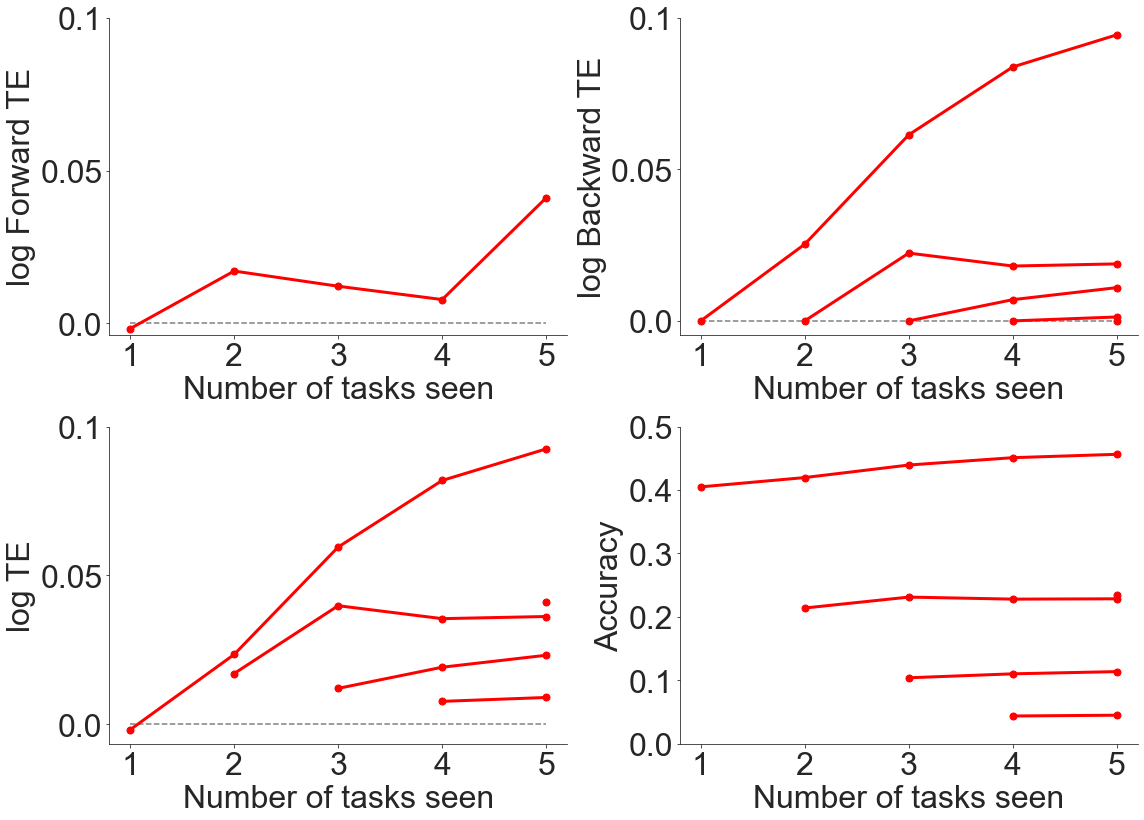

In [6]:
fn.plot_ftebte(num_tasks, err, bte, fte, te)

As can be seen from above, there is generally positive forwards and backwards transfer efficiency when evaluating transfer across datasets, even though the datasets contained very different content.

### Varying the Number of Trees

We were also curious how changing the number of trees would affect the results of the FTE/BTE experiment across datasets, and therefore also reran the experiment using `50` trees:

In [9]:
##### MAIN HYPERPARAMS ##################
model = "odif"
num_tasks = 5
num_trees = 50
reps = 4
#########################################

Running the experiment, we find the following results:

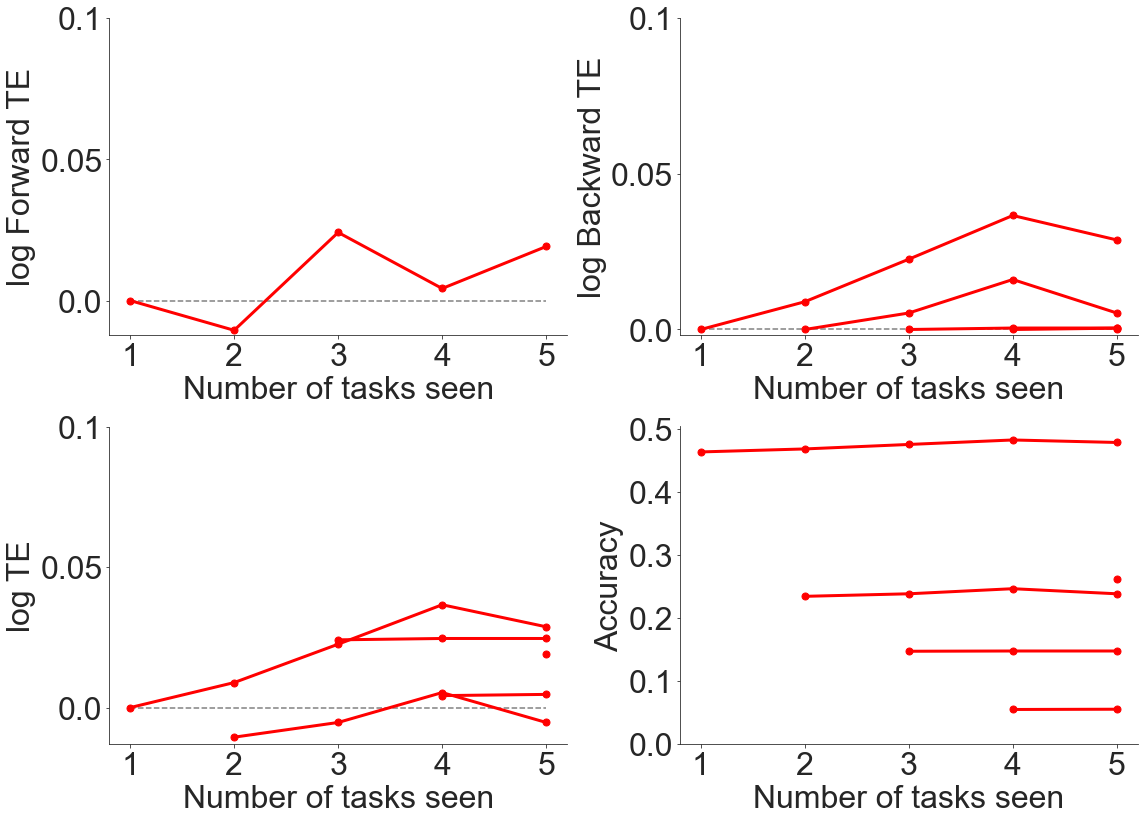

In [10]:
accuracy_all_task = fn.ftebte_exp(
    data, classes, model, num_tasks, num_trees, reps, shift=0
)
err, bte, fte, te = fn.get_metrics(accuracy_all_task, num_tasks)
fn.plot_ftebte(num_tasks, err, bte, fte, te)

It seems as if more trees leads to lower transfer efficiency. 

We use `10` trees for the remainder of the experiments to save on computing power.

## Recruitment Experiment

Now that we have roughly assessed the performance of ODIF via the FTE/BTE experiment, we are also interested in which recruitment scheme works the best for this set of data.

### Base Experiment

To quickly reiterate some of the background on the recruitment experiment, there are generally two main schemes for developing lifelong learning algorithms: building and reallocating. The former involves adding new resources as new data comes in, whereas the latter involves compressing current representations to make room for new ones. We want to examine whether current resources could be better leveraged by testing a range of approaches:
1. **Building (default for Omnidirectional Forest):** train `num_trees` new trees
2. **Uncertainty forest:** ignore all prior trees
3. **Recruiting:** select `num_trees` (out of all 450 existing trees) that perform best on the newly introduced 10th task
4. **Hybrid:** builds `num_trees/2` new trees AND recruits `num_trees/2` best-forming trees

We compare the results of these approaches based on varying training sample sizes, in the range of `[1, 5, 10, 25]` samples per label.

#### Define Hyperparameters

As always, we define the hyperparameters:
- `num_tasks`: number of tasks
- `num_trees`: nuber of trees
- `reps`: number of repetitions
- `estimation_set`: size of set used to train for the last task, as a proportion (`1-estimation_set` is the size of the set used for validation, aka the selection of best trees)

In [11]:
############################
### Main hyperparameters ###
############################
num_tasks = 5
num_trees = 10
reps = 4
estimation_set = 0.63

#### Run Experiment and Plot Results

We call our experiment function and input the main hyperparameters:

In [12]:
# run recruitment experiment
means, stds, last_task_sample = fn.recruitment_exp(
    data, classes, num_tasks, num_trees, reps, estimation_set, shift=0
)

And then we plot the results:

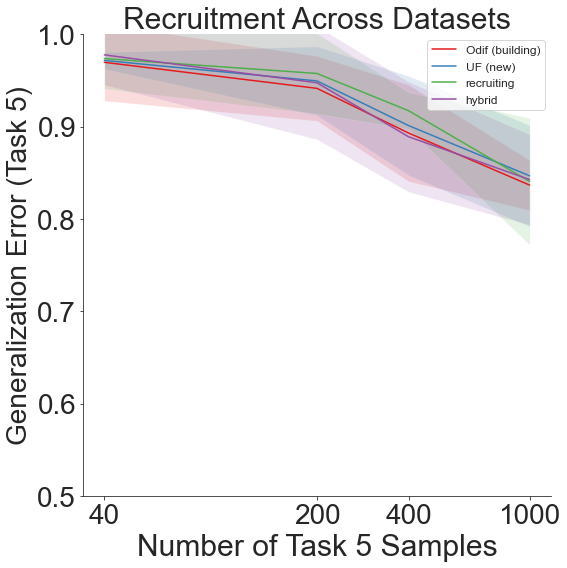

In [13]:
# plot results
fn.recruitment_plot(means, stds, last_task_sample, num_tasks)

We therefore see that though generalization error remains high on the final task, the lifelong learning algorithm still outperforms the other recruitment schemes overall.

### Shifting Dataset Order

Since the above experiment involves fixing DTD as the final dataset, a further experiment involves shifting the order of datasets, so that there is a different dataset as task 5 each time. This allows us to see whether different dataset content would significantly impact the results on the final task. 

To do so, we define the `shift` parameter in our call to the `recruitment_exp` function. This, in turn, calls the `shift_data` function, which moves the first task to the end and thus reorders the sequence of tasks.

More specifically, if we define `shift=1`, as done below, we would get the following order of datasets:
1. CIFAR-10
2. CIFAR-100
3. Food-101
4. DTD
5. Caltech-101

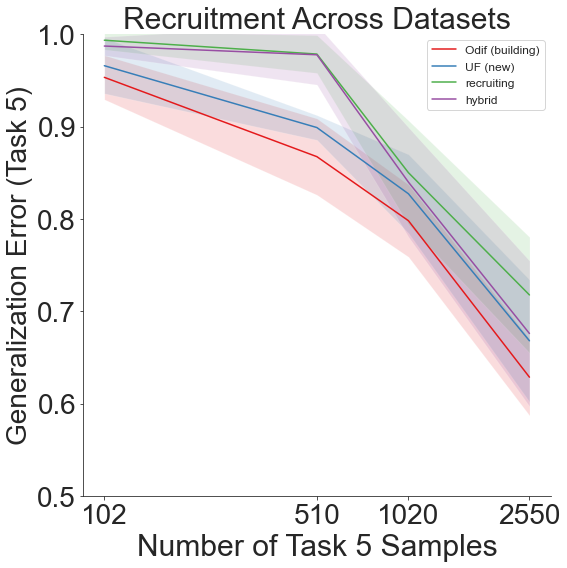

In [14]:
# run recruitment experiment
means, stds, last_task_sample = fn.recruitment_exp(
    data, classes, num_tasks, num_trees, reps, estimation_set, shift=1
)
# plot results
fn.recruitment_plot(means, stds, last_task_sample, num_tasks)

A `shift=2` results in a dataset order of:
1. CIFAR-100
2. Food-101
3. DTD
4. Caltech-101
5. CIFAR-10

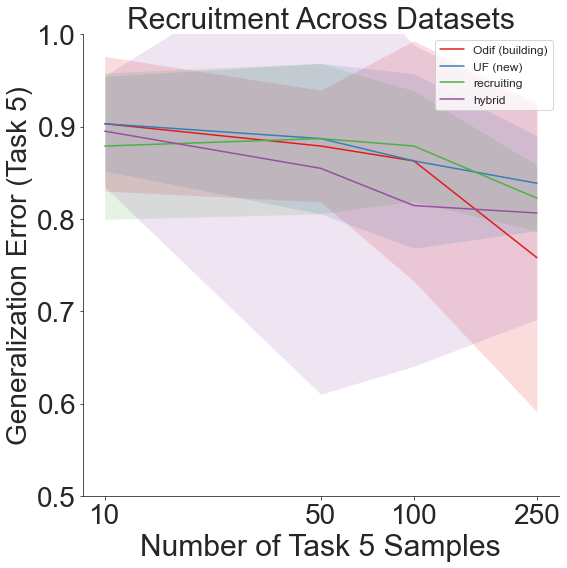

In [15]:
# run recruitment experiment
means, stds, last_task_sample = fn.recruitment_exp(
    data, classes, num_tasks, num_trees, reps, estimation_set, shift=2
)
# plot results
fn.recruitment_plot(means, stds, last_task_sample, num_tasks)

`shift=3` gives us:
1. Food-101
2. DTD
3. Caltech-101
4. CIFAR-10
5. CIFAR-100

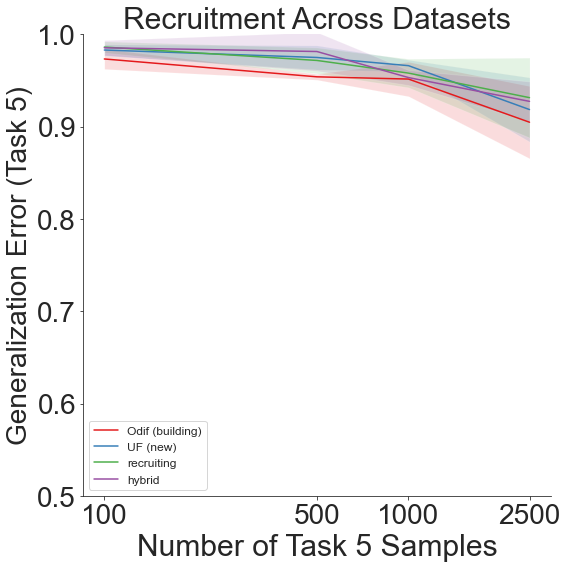

In [16]:
# run recruitment experiment
means, stds, last_task_sample = fn.recruitment_exp(
    data, classes, num_tasks, num_trees, reps, estimation_set, shift=3
)
# plot results
fn.recruitment_plot(means, stds, last_task_sample, num_tasks)

And finally, `shift=4` yields:
1. DTD
2. Caltech-101
3. CIFAR-10
4. CIFAR-100
5. Food-101

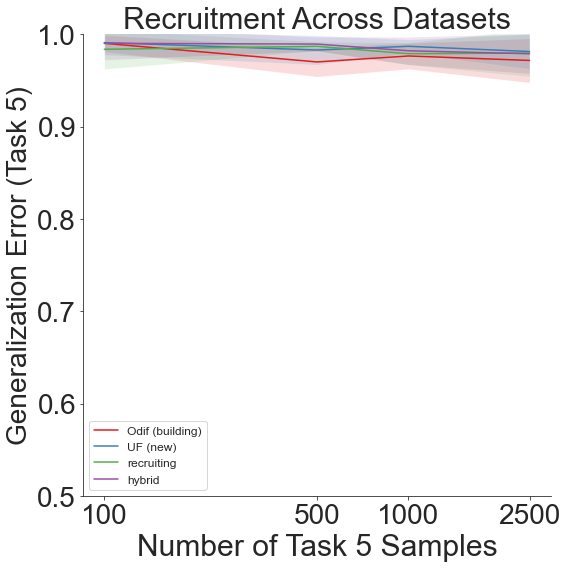

In [17]:
# run recruitment experiment
means, stds, last_task_sample = fn.recruitment_exp(
    data, classes, num_tasks, num_trees, reps, estimation_set, shift=4
)
# plot results
fn.recruitment_plot(means, stds, last_task_sample, num_tasks)

Throughout all the above experiments, even though generalization error remains high due to the sheer amount of different labels across all the different datsets, our lifelong learning algorithm still outperforms the other recruitment methods.

## Other Experiments

### Effect of Normalization

When examining data across different datasets, normalization and standardization of data is often of interest. However, this can also lead to loss of information, as we are placing all the images on the same scale. As a final experiment, we also look into the effect of normalization on the FTE/BTE results.

#### Import and Process Data

The `import_data` function has a `normalize` parameter, where one can specify whether they want to normalize the data, normalize across the dataset, or just normalize across each image. Previously, for the original FTE/BTE experiment, we set `normalize=False`.

Here, we look at the other two options.

In [18]:
# normalize across dataset
data1, classes1 = fn.import_data(normalize="dataset")

In [19]:
# normalize across each image
data2, classes2 = fn.import_data(normalize="image")

#### Define Hyperparameters

We use the same parameters as before:

In [20]:
##### MAIN HYPERPARAMS ##################
model = "odif"
num_tasks = 5
num_trees = 10
reps = 4
#########################################

#### Run Experiment and Plot Results

We first run the FTE/BTE experiment by normalizing across each dataset, such that the images in each dataset have a range of [0,1] in each channel.

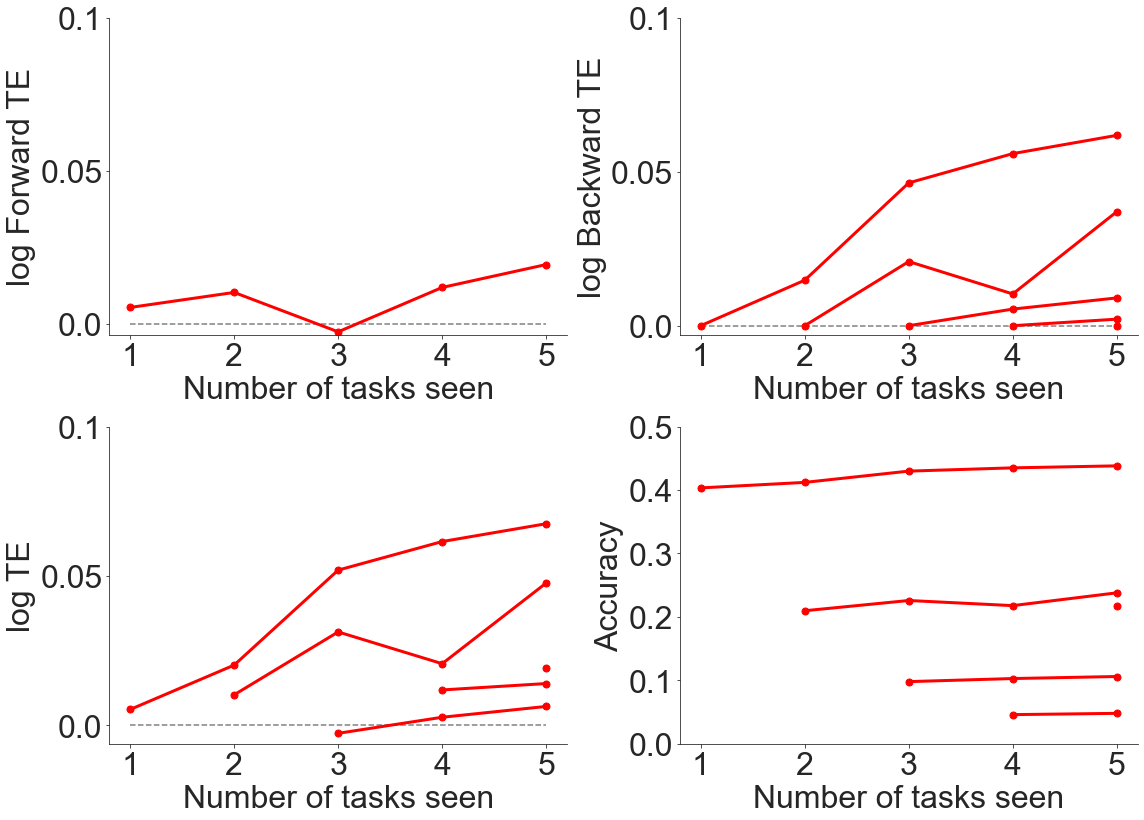

In [21]:
accuracy_all_task = fn.ftebte_exp(
    data1, classes1, model, num_tasks, num_trees, reps, shift=0
)
err, bte, fte, te = fn.get_metrics(accuracy_all_task, num_tasks)
fn.plot_ftebte(num_tasks, err, bte, fte, te)

We then run the FTE/BTE experiment with normalizing per image, so that each channel in each image is scaled to a range of [0,1].

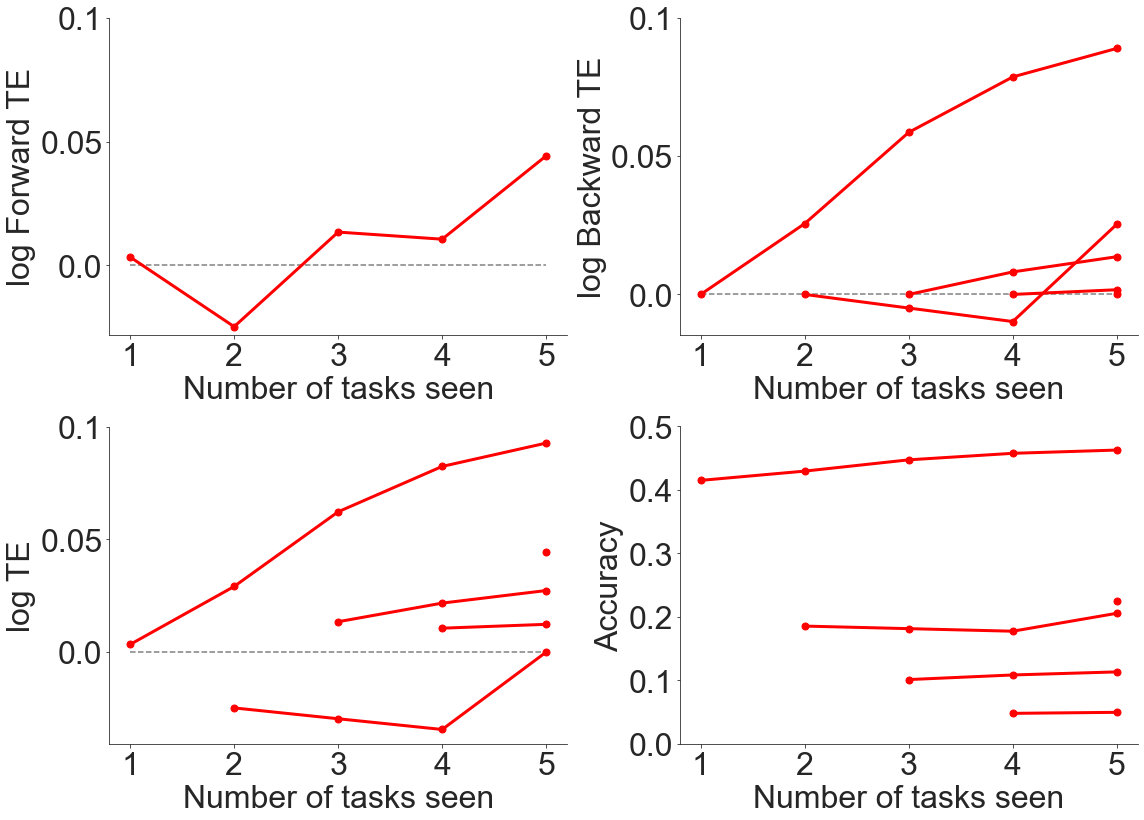

In [22]:
accuracy_all_task = fn.ftebte_exp(
    data2, classes2, model, num_tasks, num_trees, reps, shift=0
)
err, bte, fte, te = fn.get_metrics(accuracy_all_task, num_tasks)
fn.plot_ftebte(num_tasks, err, bte, fte, te)

It seems as if normalizing both across the dataset and within each image yield relatively similar results to not normalizing, so we did not perform further experiments to explore this area more at the current point in time.